In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline

In [2]:
monthly_01_20raw = pd.read_csv(r'../CSV/datos_mes_01_20.csv')

monthly_01_20raw['FECHA'] = pd.to_datetime(monthly_01_20raw['FECHA'], format = '%Y-%m-%d')

monthly_01_20raw = monthly_01_20raw.set_index(['FECHA'])

In [3]:
monthly_df = monthly_01_20raw.groupby(['FECHA']).agg('mean')
monthly_df2 = monthly_df.resample('M').mean()

In [4]:
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 238 entries, 2001-01-31 to 2020-10-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BEN     238 non-null    float64
 1   NO_2    238 non-null    float64
 2   O_3     238 non-null    float64
 3   TCH     238 non-null    float64
dtypes: float64(4)
memory usage: 9.3 KB


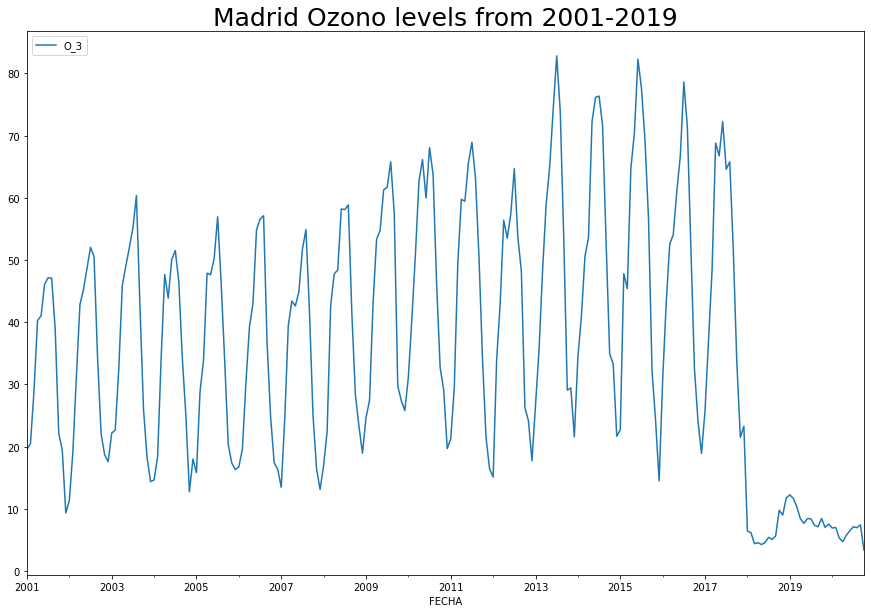

In [7]:
col_list = ['O_3']
plt_monthly = monthly_df2[col_list]
plt_monthly.plot(figsize=(15, 10))
plt.title('Madrid Ozono levels from 2001-2019', fontsize=25)
plt.legend(loc='upper left')
plt.show()

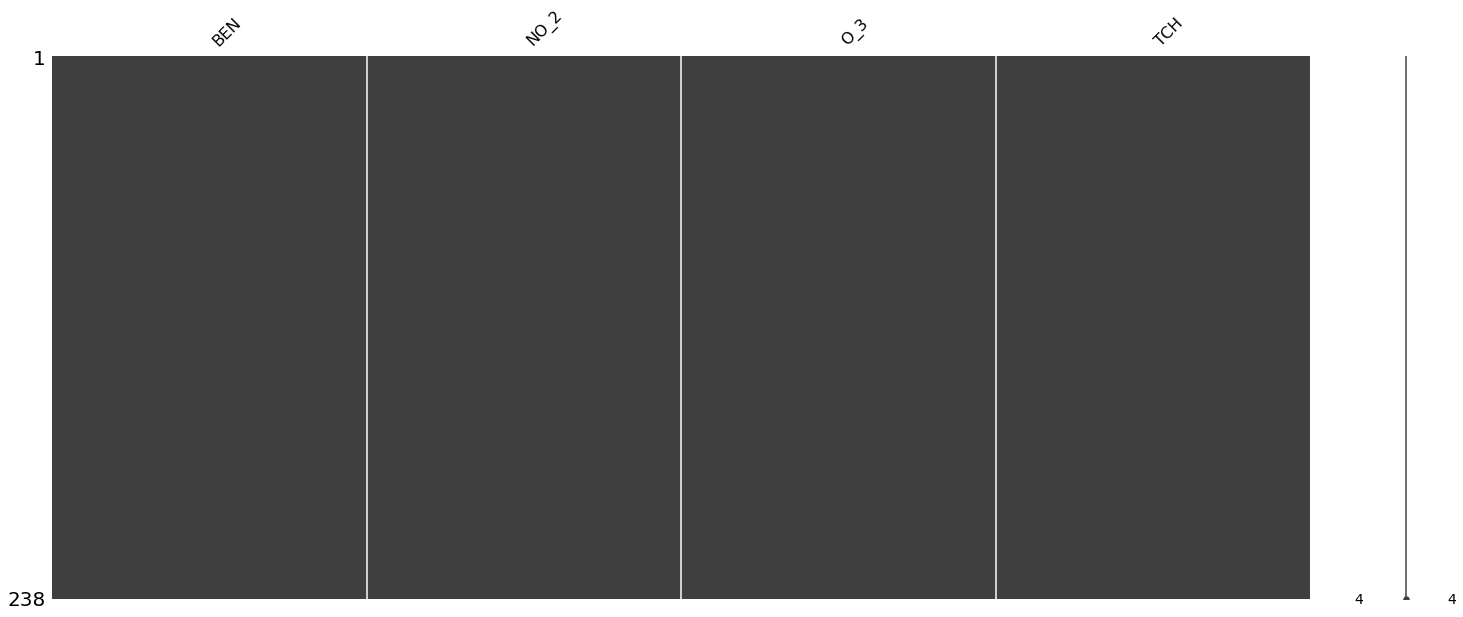

In [8]:
msno.matrix(monthly_df2);

--------Multiplicative-------
--------Additive-------


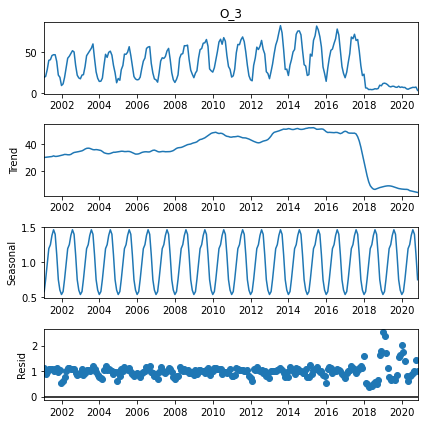

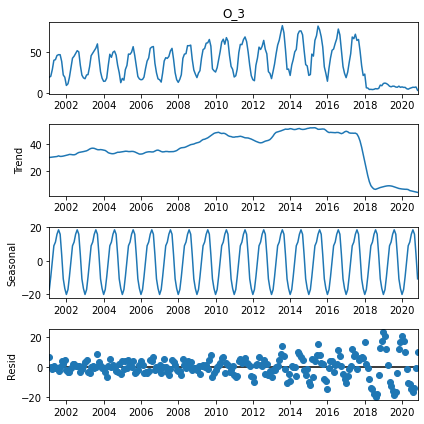

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
result_mul = seasonal_decompose(plt_monthly['O_3'], model = 'multiplicative', extrapolate_trend = 'freq')

# Additive Decomposition

result_add = seasonal_decompose(plt_monthly['O_3'], model = 'additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
print("--------Multiplicative-------")
result_mul.plot() 
print("--------Additive-------")
result_add.plot();
#plt.show()

In [18]:
monthly_arima_raw = pd.read_csv(r'../CSV/datos_mes_01_20.csv')

monthly_arima_raw['FECHA'] = pd.to_datetime(monthly_arima_raw['FECHA'], format = '%Y-%m-%d')


monthly_arima = monthly_arima_raw.loc[(monthly_arima_raw['FECHA'].dt.year == 2018)|
               (monthly_arima_raw['FECHA'].dt.year == 2019)|
               (monthly_arima_raw['FECHA'].dt.year == 2020)
               ]

monthly_arima = monthly_arima.set_index(['FECHA'])

monthly_arima_clean = monthly_arima[['O_3']]

--------Multiplicative-------
--------Additive-------


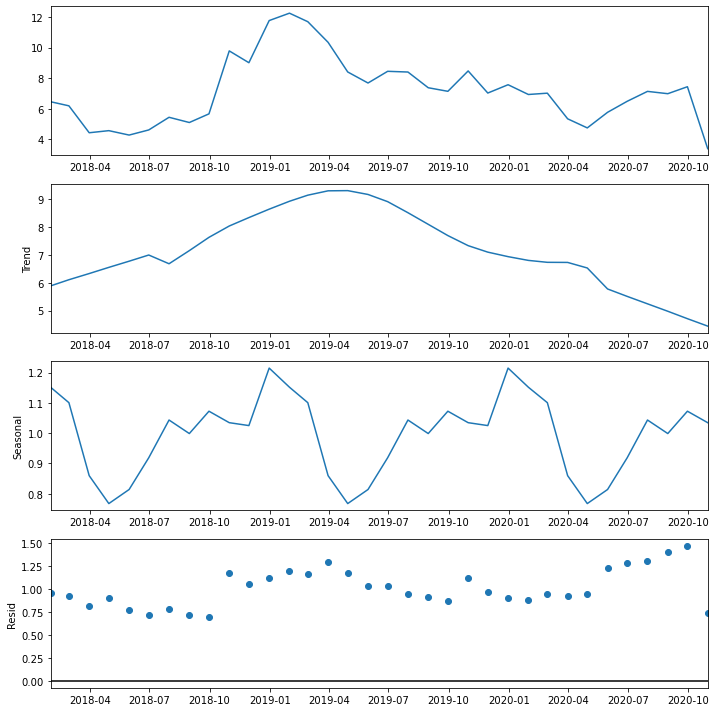

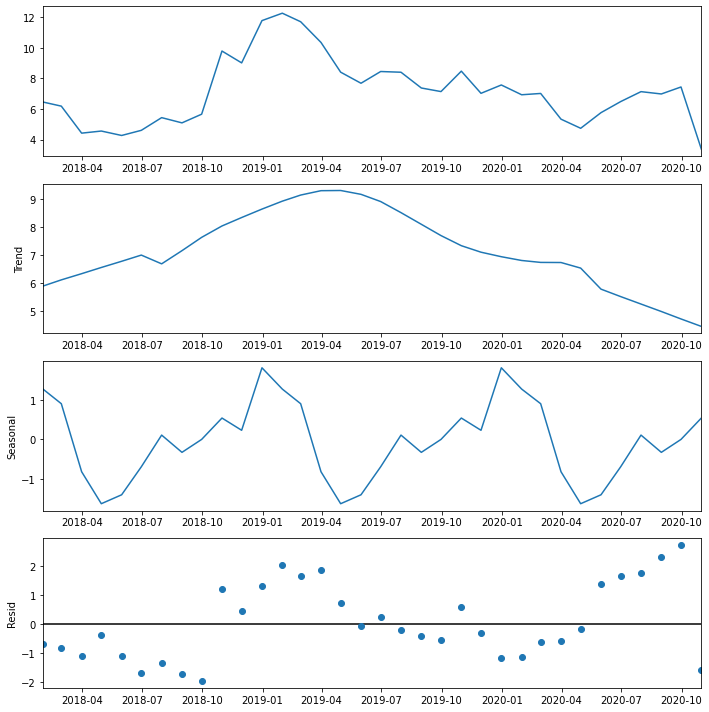

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
result_mul = seasonal_decompose(monthly_arima_clean, model = 'multiplicative', extrapolate_trend = 'freq')

# Additive Decomposition

result_add = seasonal_decompose(monthly_arima_clean, model = 'additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
print("--------Multiplicative-------")
result_mul.plot()
print("--------Additive-------")
result_add.plot();
#plt.show(

In [38]:
monthly_arima_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34 entries, 2018-01-31 to 2020-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   O_3     34 non-null     float64
dtypes: float64(1)
memory usage: 544.0 bytes


In [21]:
X = monthly_arima_clean['O_3'].values
train = X[:24]
test = X[24:]
test

array([6.93225806, 7.01785714, 5.33870968, 4.74333333, 5.76451613,
       6.48666667, 7.13548387, 6.98387097, 7.44      , 3.38387097])

In [22]:
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m = 12,
                    trace=True,
                    stepwise=True,
                  random_state=42,
                  sesionality = True)

print(model.aic())

predictions = model.predict(10)
print("mean_squared_error:", mean_squared_error(test, predictions))
print("root_mean_squared_error:", np.sqrt(mean_squared_error(test, predictions)))

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=90.572, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=112.827, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=87.141, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=101.223, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=169.561, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=86.920, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=87.231, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=88.857, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=88.804, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=88.849, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=99.343, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=90.311, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=89.861, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.886 seconds
86.92045433108032
mean_squared_

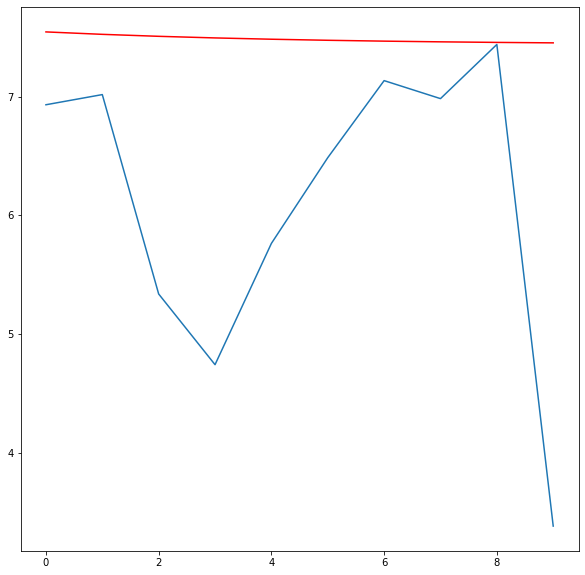

In [23]:
plt.plot(test)
plt.plot(predictions,color='red');

In [26]:
exogenous = monthly_df2[['NO_2']][:24].values.reshape(-1,1)

In [27]:
model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m = 12,
                    trace=True,
                    stepwise=True,
                   random_state=42,
                   sesionality = True,
                   exogenous= exogenous)
print(model.summary())

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=87.831, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=84.273, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=84.273, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=82.304, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=82.308, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=84.308, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=86.081, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=86.124, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=88.020, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.999 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:      

In [32]:
predictions = model.predict(10,
                           exogenous = monthly_df2[['NO_2']][:10].values.reshape(-1,1))
print("mean_squared_error:", mean_squared_error(test, predictions))
print("root_mean_squared_error:", np.sqrt(mean_squared_error(test, predictions)))

mean_squared_error: 3.746464737526737
root_mean_squared_error: 1.9355786570239757


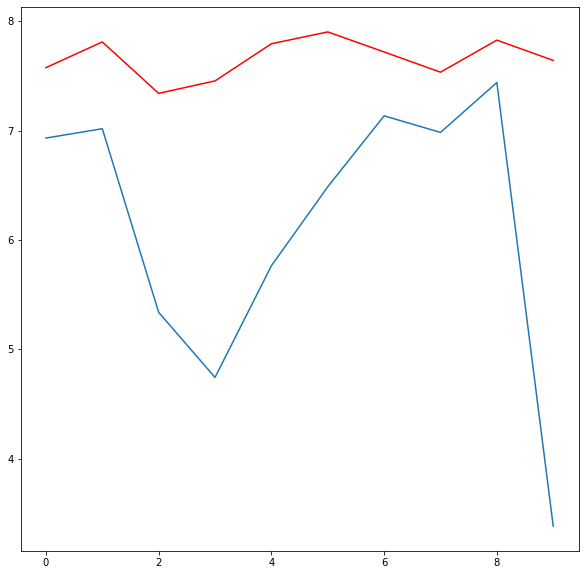

In [33]:
plt.plot(test)
plt.plot(predictions,color='red');